In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
df = pd.read_pickle('male_test.pkl')
import os
import pickle
from glob import glob
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, ElasticNetCV
from datetime import datetime

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def age_deconfounding(predicted_ages, chronological_ages):
    
    if isinstance(predicted_ages, pd.Series):
        predicted_ages = predicted_ages.to_numpy()
    
    if isinstance(chronological_ages, pd.Series):
        chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

In [3]:
from sklearn.model_selection import train_test_split

df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjects_testA = df_testA['Unnamed: 0'].to_list()
subjects_testB = df_testB['Unnamed: 0'].to_list()
df_testA = df_testA.drop(labels='Unnamed: 0', axis=1)
df_testB = df_testB.drop(labels='Unnamed: 0', axis=1)

df_train = df_testA
df_test = df_testB

In [4]:
Xtrain = df_train.loc[:, df_train.columns != 'target_age']
Ytrain = df_train['target_age']

Xtest = df_test.loc[:, df_test.columns != 'target_age']
Ytest = df_test['target_age']

In [5]:
Xtrain = Xtrain.to_numpy()
Ytrain = Ytrain.to_numpy()
Xtest = Xtest.to_numpy()
Ytest = Ytest.to_numpy()

In [6]:
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(2182, 57) (2182,)
(2183, 57) (2183,)


In [7]:
type(Xtrain[0,0])

numpy.float64

In [8]:
start_time = datetime.now()
regr = MLPRegressor(hidden_layer_sizes = [200,200], random_state=1, max_iter=1000).fit(Xtrain, Ytrain)
end_time = datetime.now()
Yhat = regr.predict(Xtest)

MAE= 2.219501606525866
PR= 0.9304999183252188
Time To Complete: 0:00:04.848787
MAE Decon= 2.3612274696105233
PR Decon= 0.9304999183252186


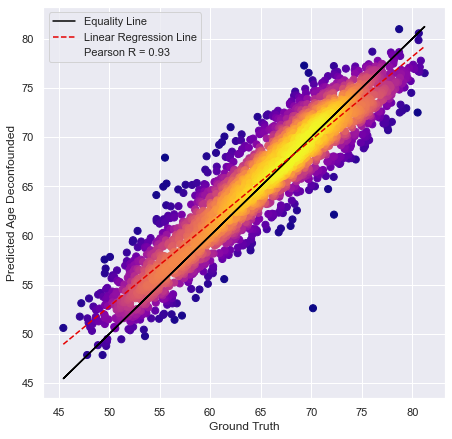

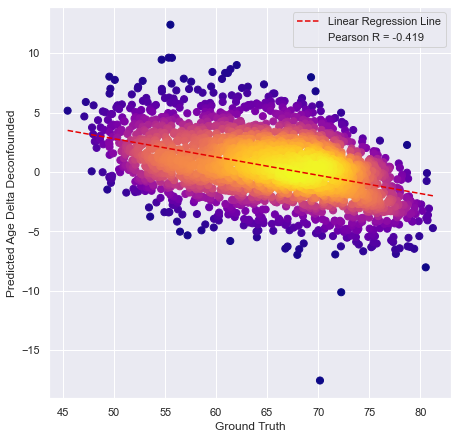

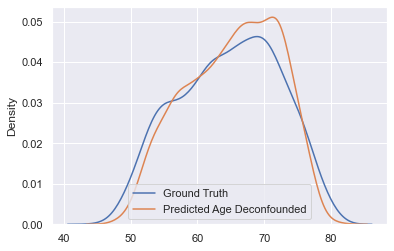

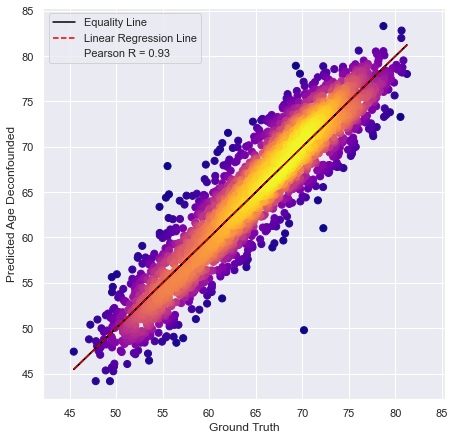

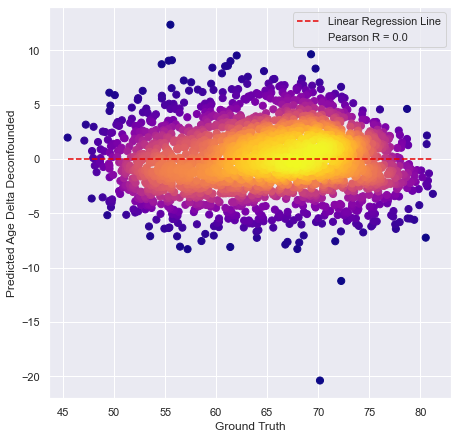

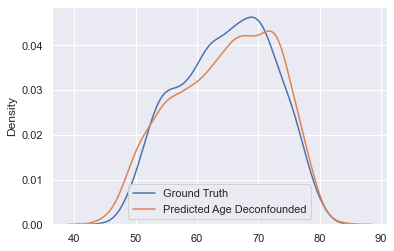

In [9]:
deconfound = True
verbose = True
show_plots = True

Age_Deltas = Yhat - Ytest

if deconfound == True:
    Yhat_decon = age_deconfounding(Yhat, Ytest)
    Age_Deltas_decon = Yhat_decon - Ytest
else:
    Yhat_decon = None
    Age_Deltas_decon = None
    
mae = np.abs(Age_Deltas).mean()
pr = pearsonr(Ytest, Yhat)[0]

if deconfound == True:
    mae_decon = np.abs(Age_Deltas_decon).mean()
    pr_decon = pearsonr(Ytest, Yhat_decon)[0]
else:
    mae_decon = None
    pr_decon = None

if verbose == True:
    print('MAE=', mae)
    print('PR=', pr)
    print('Time To Complete: {}'.format(end_time - start_time))
    if deconfound == True:
        print('MAE Decon=', mae_decon)
        print('PR Decon=', pr_decon)

if show_plots == True:
    scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                           ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

    scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                           ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                           equality_line=False)

    kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

    if deconfound == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            

# 1. Grid Search To Determine Best Parameter Combination - NOT FOR MALE

In [10]:
# mlp = MLPRegressor(max_iter=1000, random_state=1)

# parameter_space = {
#     'hidden_layer_sizes': [
#                             (25,), (50,), (100,), (150,), (200,),
#                             (25, 25),
#                             (50, 50),
#                             (100, 100),
#                             (150, 100),
#                             (200, 100), (200, 200),
#                             (25, 25, 25),
#                             (50, 50, 50),
#                             (100, 100, 50), (100, 100, 100),
#                             (200, 100, 50), (200, 200, 100), (200, 200, 200),
#     ],
    
#     'activation': ['tanh', 'relu'],
#     'solver': ['adam'],
#     'learning_rate': ['constant','adaptive'],
# }

# from sklearn.model_selection import GridSearchCV

# clf = GridSearchCV(mlp, parameter_space, verbose=2, cv=5, scoring='neg_mean_absolute_error')
# clf.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.3s
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.1s
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.4s
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.2s
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.3s
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=adaptive, solver=adam, total=   2.5s
[CV] activation=tanh, hidden_layer_sizes=(25,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25,), learning_rate=adaptive, so

[CV]  activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200,), learning_rate=adaptive, solver=adam, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(25, 25), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25, 25), learning_rate=constant, solver=adam, total=   3.7s
[CV] activation=tanh, hidden_layer_sizes=(25, 25), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25, 25), learnin

[CV]  activation=tanh, hidden_layer_sizes=(150, 100), learning_rate=adaptive, solver=adam, total=   2.8s
[CV] activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam, total=   3.2s
[CV] activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam, total=   3.3s
[CV] activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam, total=   3.5s
[CV] activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam, total=   3.6s
[CV] activation=tanh, hidden_layer_sizes=(200, 100), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hi

[CV]  activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam, total=   6.0s
[CV] activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam, total=   6.2s
[CV] activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam, total=   6.4s
[CV] activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=constant, solver=adam, total=   6.0s
[CV] activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=adaptive, solver=adam, total=   6.5s
[CV] activation=tanh, hidden_layer_sizes=(100, 100, 50), learning_rate=adaptive

[CV]  activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=constant, solver=adam, total=   4.4s
[CV] activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=constant, solver=adam, total=   4.6s
[CV] activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=constant, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=constant, solver=adam, total=   3.9s
[CV] activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=adaptive, solver=adam, total=   3.4s
[CV] activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rate=adaptive, solver=adam, total=   3.7s
[CV] activation=tanh, hidden_layer_sizes=(200, 200, 200), learning_rat

[CV]  activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150,), learning_rate=adaptive, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(200,), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(200,), learning_rate=constant, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(200,), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(200,), learning_rate=c

[CV]  activation=relu, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(150, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hi

[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV] 

[CV]  activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=constant, solver=adam, total=   3.5s
[CV] activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=constant, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=adaptive, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rate=adaptive, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(200, 200, 100), learning_rat

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 15.2min finished


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000, random_state=1),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(25,), (50,), (100,), (150,),
                                                (200,), (25, 25), (50, 50),
                                                (100, 100), (150, 100),
                                                (200, 100), (200, 200),
                                                (25, 25, 25), (50, 50, 50),
                                                (100, 100, 50), (100, 100, 100),
                                                (200, 100, 50), (200, 200, 100),
                                                (200, 200, 200)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam']},
             scoring='neg_mean_absolute_error', verbose=2)

In [11]:
# # Best paramete set
# print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [12]:
# # All results
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

-6.511 (+/-0.704) for {'activation': 'tanh', 'hidden_layer_sizes': (25,), 'learning_rate': 'constant', 'solver': 'adam'}
-6.511 (+/-0.704) for {'activation': 'tanh', 'hidden_layer_sizes': (25,), 'learning_rate': 'adaptive', 'solver': 'adam'}
-6.716 (+/-1.202) for {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
-6.716 (+/-1.202) for {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
-6.322 (+/-0.281) for {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
-6.322 (+/-0.281) for {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
-6.203 (+/-0.457) for {'activation': 'tanh', 'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'solver': 'adam'}
-6.203 (+/-0.457) for {'activation': 'tanh', 'hidden_layer_sizes': (150,), 'learning_rate': 'adaptive', 'solver': 'adam'}
-6.226 (+/-0.405) for {'acti

In [13]:
# df = pd.DataFrame.from_dict(clf.cv_results_)

In [14]:
# df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.266205,0.082828,0.000570,0.000021,tanh,"(25,)",constant,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",-6.896398,-6.700762,-6.001719,-6.183361,-6.771074,-6.510663,0.351822,69
1,2.390821,0.101560,0.000558,0.000025,tanh,"(25,)",adaptive,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",-6.896398,-6.700762,-6.001719,-6.183361,-6.771074,-6.510663,0.351822,69
2,1.351170,0.216034,0.000786,0.000202,tanh,"(50,)",constant,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",-7.619714,-6.016874,-6.173842,-7.158029,-6.610013,-6.715694,0.601005,71
3,1.470037,0.235987,0.000673,0.000024,tanh,"(50,)",adaptive,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",-7.619714,-6.016874,-6.173842,-7.158029,-6.610013,-6.715694,0.601005,71
4,1.323795,0.128467,0.001218,0.000252,tanh,"(100,)",constant,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",-6.401976,-6.172278,-6.253079,-6.224188,-6.557800,-6.321864,0.140522,67


In [15]:
# df.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
61,1.439583,0.451332,0.001138,0.000055,relu,"(50, 50, 50)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.124053,-2.077150,-2.160696,-2.259720,-2.261125,-2.176549,0.073427,1
60,1.435735,0.457521,0.001549,0.000523,relu,"(50, 50, 50)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.124053,-2.077150,-2.160696,-2.259720,-2.261125,-2.176549,0.073427,1
65,1.445209,0.301335,0.003547,0.000189,relu,"(100, 100, 100)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.385186,-2.234809,-2.138396,-2.206747,-2.166037,-2.226235,0.086091,3
64,1.370281,0.290223,0.003412,0.000209,relu,"(100, 100, 100)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.385186,-2.234809,-2.138396,-2.206747,-2.166037,-2.226235,0.086091,3
46,1.260900,0.387087,0.000833,0.000162,relu,"(25, 25)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.107759,-2.235917,-2.324725,-2.329040,-2.406699,-2.280828,0.102044,5
47,1.256757,0.353941,0.000728,0.000047,relu,"(25, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.107759,-2.235917,-2.324725,-2.329040,-2.406699,-2.280828,0.102044,5
58,2.011888,0.476058,0.001105,0.000214,relu,"(25, 25, 25)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.385062,-2.165821,-2.264201,-2.378394,-2.377420,-2.314180,0.086782,7
59,1.996208,0.471011,0.000928,0.000085,relu,"(25, 25, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.385062,-2.165821,-2.264201,-2.378394,-2.377420,-2.314180,0.086782,7
48,1.063465,0.227869,0.001050,0.000256,relu,"(50, 50)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.150378,-2.197761,-2.223790,-2.733565,-2.311754,-2.323450,0.211667,9
49,1.077618,0.241270,0.000901,0.000044,relu,"(50, 50)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.150378,-2.197761,-2.223790,-2.733565,-2.311754,-2.323450,0.211667,9


In [16]:
# Yhat = clf.predict(Xtest)

MAE= 2.1547864344817307
PR= 0.9311785859968067
Time To Complete: 0:00:01.426653
MAE Decon= 2.270749903465692
PR Decon= 0.9311785859968069


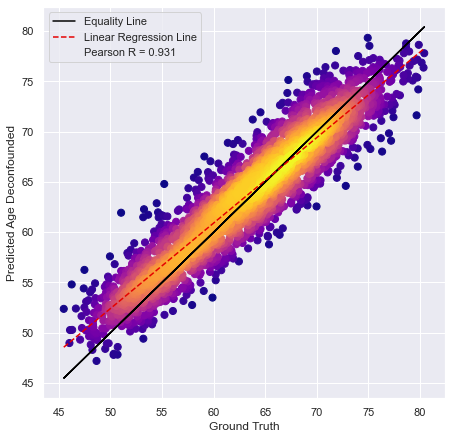

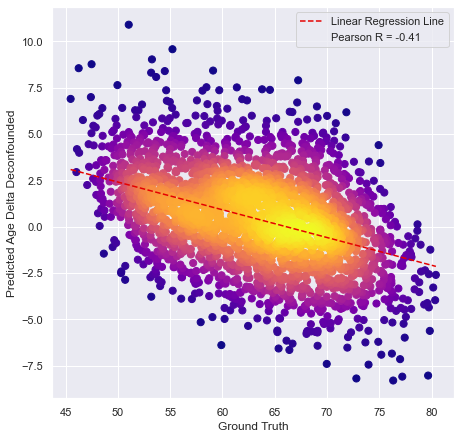

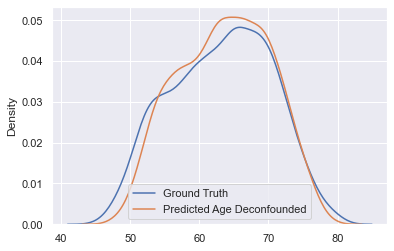

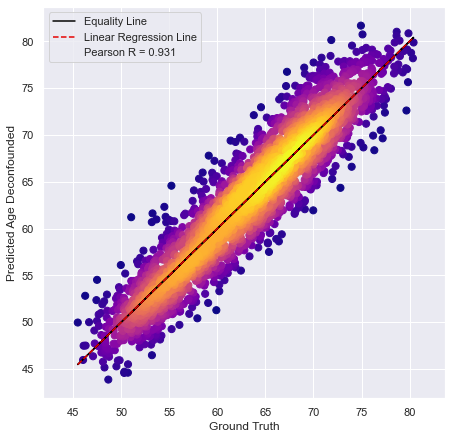

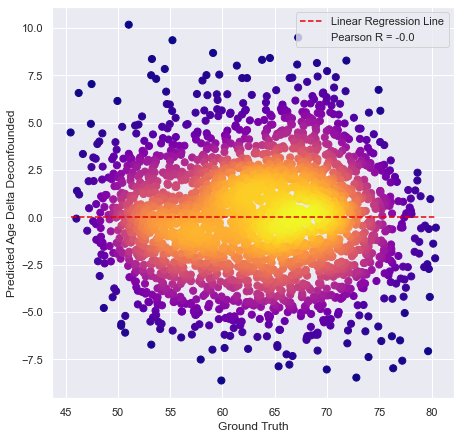

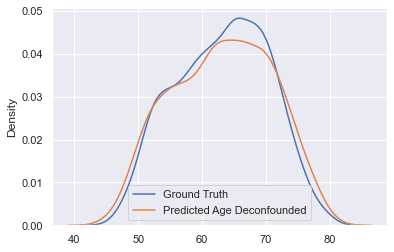

In [17]:
# deconfound = True
# verbose = True
# show_plots = True

# Age_Deltas = Yhat - Ytest

# if deconfound == True:
#     Yhat_decon = age_deconfounding(Yhat, Ytest)
#     Age_Deltas_decon = Yhat_decon - Ytest
# else:
#     Yhat_decon = None
#     Age_Deltas_decon = None
    
# mae = np.abs(Age_Deltas).mean()
# pr = pearsonr(Ytest, Yhat)[0]

# if deconfound == True:
#     mae_decon = np.abs(Age_Deltas_decon).mean()
#     pr_decon = pearsonr(Ytest, Yhat_decon)[0]
# else:
#     mae_decon = None
#     pr_decon = None

# if verbose == True:
#     print('MAE=', mae)
#     print('PR=', pr)
#     print('Time To Complete: {}'.format(end_time - start_time))
#     if deconfound == True:
#         print('MAE Decon=', mae_decon)
#         print('PR Decon=', pr_decon)

# if show_plots == True:
#     scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
#                            ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

#     scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
#                            ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                            equality_line=False)

#     kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

#     if deconfound == True:
#         scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

#         scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                                equality_line=False)

#         kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            

MAE= 2.254548859874442
PR= 0.9276876133940383
Time To Complete: 0:00:02.970480
MAE Decon= 2.337971040840924
PR Decon= 0.9276876133940382


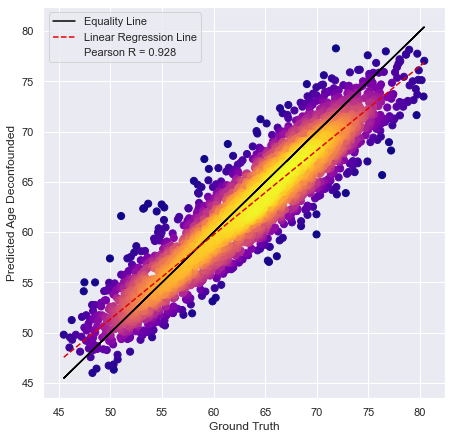

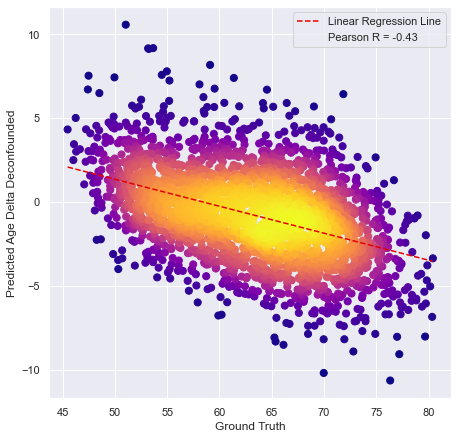

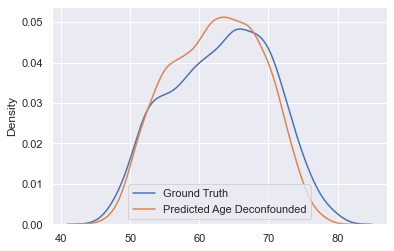

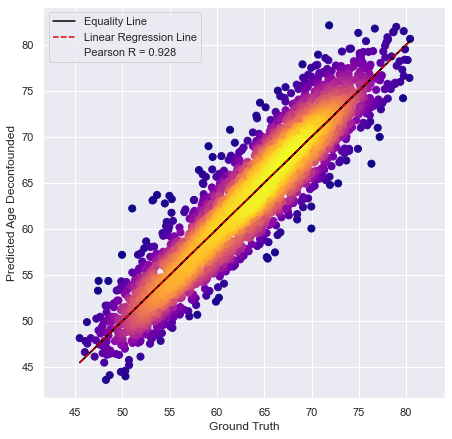

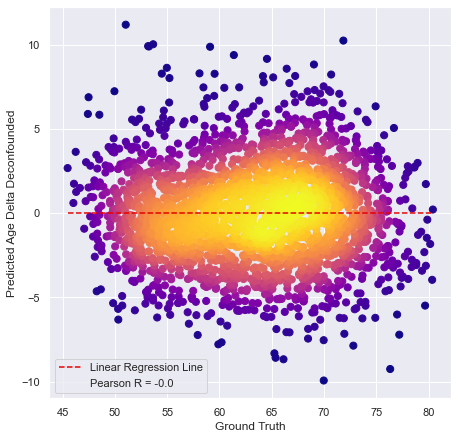

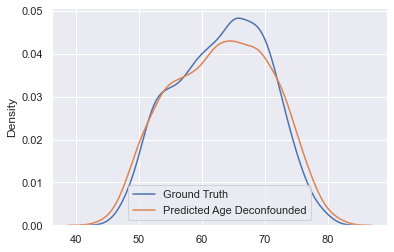

In [18]:
# start_time = datetime.now()
# regr = MLPRegressor(hidden_layer_sizes = [50,50, 50], max_iter=1000, learning_rate='adaptive').fit(Xtrain, Ytrain)
# # MAYBE TRAIN MULTIPLE ONES AND THEN AVERAGE, to eliminate weight initialisation biases.

# end_time = datetime.now()
# Yhat = regr.predict(Xtest)

# deconfound = True
# verbose = True
# show_plots = True

# Age_Deltas = Yhat - Ytest

# if deconfound == True:
#     Yhat_decon = age_deconfounding(Yhat, Ytest)
#     Age_Deltas_decon = Yhat_decon - Ytest
# else:
#     Yhat_decon = None
#     Age_Deltas_decon = None
    
# mae = np.abs(Age_Deltas).mean()
# pr = pearsonr(Ytest, Yhat)[0]

# if deconfound == True:
#     mae_decon = np.abs(Age_Deltas_decon).mean()
#     pr_decon = pearsonr(Ytest, Yhat_decon)[0]
# else:
#     mae_decon = None
#     pr_decon = None

# if verbose == True:
#     print('MAE=', mae)
#     print('PR=', pr)
#     print('Time To Complete: {}'.format(end_time - start_time))
#     if deconfound == True:
#         print('MAE Decon=', mae_decon)
#         print('PR Decon=', pr_decon)

# if show_plots == True:
#     scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
#                            ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

#     scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
#                            ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                            equality_line=False)

#     kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

#     if deconfound == True:
#         scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

#         scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                                equality_line=False)

#         kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            

In [19]:
# df.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
61,1.439583,0.451332,0.001138,0.000055,relu,"(50, 50, 50)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.124053,-2.077150,-2.160696,-2.259720,-2.261125,-2.176549,0.073427,1
60,1.435735,0.457521,0.001549,0.000523,relu,"(50, 50, 50)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.124053,-2.077150,-2.160696,-2.259720,-2.261125,-2.176549,0.073427,1
65,1.445209,0.301335,0.003547,0.000189,relu,"(100, 100, 100)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.385186,-2.234809,-2.138396,-2.206747,-2.166037,-2.226235,0.086091,3
64,1.370281,0.290223,0.003412,0.000209,relu,"(100, 100, 100)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.385186,-2.234809,-2.138396,-2.206747,-2.166037,-2.226235,0.086091,3
46,1.260900,0.387087,0.000833,0.000162,relu,"(25, 25)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.107759,-2.235917,-2.324725,-2.329040,-2.406699,-2.280828,0.102044,5


In [20]:
# mlp = MLPRegressor(max_iter=10000, random_state=1)

# parameter_space = {
#     'hidden_layer_sizes': [
        
#                             (25,), (50,), (75,), (100,),
        
#                             (25, 25),
#                             (50, 25), (50, 50),
#                             (75, 25), (75, 50), (75, 75),
#                             (100, 25), (100, 50), (100, 75), (100, 100),
#                             (125, 25), (125, 50), (125, 75), (125, 100), (125, 125),
        
#                             (25, 25, 25),
#                             (50, 25, 25), (50, 50, 25), (50, 50, 50),
#                             (75, 25, 25), (75, 50, 25), (75, 50, 50), (75, 75, 25), (75, 75, 50), (75, 75, 75),
#                             (100, 25, 25), (100, 50, 25), (100, 50, 50), (100, 75, 25), (100, 75, 50), (100, 75, 75),
#                             (100, 100, 25), (100, 100, 50), (100, 100, 75), (100, 100, 100),
        
#                             (25, 25, 25, 25),
        
#                             (50, 25, 25, 25),
#                             (50, 50, 25, 25),
#                             (50, 50, 50, 25),
#                             (50, 50, 50, 50),
                                   
#                             (75, 25, 25, 25),
#                             (75, 50, 25, 25),
#                             (75, 50, 50, 25),
#                             (75, 50, 50, 50),
#                             (75, 75, 25, 25),
#                             (75, 75, 50, 25),
#                             (75, 75, 50, 50),
#                             (75, 75, 75, 25), 
#                             (75, 75, 75, 50), 
#                             (75, 75, 75, 75), 
        
#                             (100, 25, 25, 25),
#                             (100, 50, 25, 25),
#                             (100, 50, 50, 25),
#                             (100, 50, 50, 50),
#                             (100, 75, 25, 25),
#                             (100, 75, 50, 25),
#                             (100, 75, 50, 50),
#                             (100, 75, 75, 25), 
#                             (100, 75, 75, 50), 
#                             (100, 75, 75, 75),
#                             (100, 100, 25, 25),
#                             (100, 100, 50, 25),
#                             (100, 100, 50, 50),
#                             (100, 100, 75, 25),
#                             (100, 100, 75, 50),
#                             (100, 100, 75, 75),
#                             (100, 100, 100, 25), 
#                             (100, 100, 100, 50), 
#                             (100, 100, 100, 75),
#                             (100, 100, 100, 100),
#     ],
    
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'learning_rate': ['constant','adaptive'],
# }

# from sklearn.model_selection import GridSearchCV

# clf = GridSearchCV(mlp, parameter_space, verbose=2, cv=5, scoring='neg_mean_absolute_error')
# clf.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 148 candidates, totalling 740 fits
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.0s
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=constant, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=adaptive, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(25,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25,), learning_rate=adaptive, so

[CV]  activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 25), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50

[CV]  activation=relu, hidden_layer_sizes=(75, 50), learning_rate=adaptive, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50), learning_rate=adaptive, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75

[CV]  activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hi

[CV]  activation=relu, hidden_layer_sizes=(125, 100), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam, total=   2.0s
[CV] activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(125, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hi

[CV]  activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam, total=   2.5s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV] 

[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50), learning_rate=adaptive, solver=adam, total=   2.5s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50), learning_rate=adaptive, solver=adam, total=   2.2s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 25), learning_rate=constant, solver=adam 
[CV] 

[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=a

[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=adaptive, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=adaptive, solver=a

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rat

[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=constant, solver=adam, total=   2.5s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=constant, solver=adam, total=   3.4s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   2.9s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(50, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   3.0s
[CV] activation=relu, hidden_layer_sizes=(50, 50, 50, 25), le

[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=constant, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=constant, solver=adam, total=   2.2s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   2.0s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), le

[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=constant, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=constant, solver=adam, total=   3.4s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   2.2s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   2.9s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), le

[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=constant, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=adaptive, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25, 25), learning_rate=adaptive, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 2

[CV]  activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=constant, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=constant, solver=adam, total=   2.3s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=adaptive, solver=adam, total=   2.2s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 25, 25), learning_rate=adaptive, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 2

[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=constant, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=adaptive, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 50), learning_rate=adaptive, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 7

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam, total=   3.1s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 50), learning_rate=adaptive, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(1

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 25), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=adaptive, solver=adam, total=   2.0s


[Parallel(n_jobs=1)]: Done 740 out of 740 | elapsed: 19.2min finished


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=10000, random_state=1),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(25,), (50,), (75,), (100,),
                                                (25, 25), (50, 25), (50, 50),
                                                (75, 25), (75, 50), (75, 75),
                                                (100, 25), (100, 50), (100, 75),
                                                (100, 100), (125, 25),
                                                (125, 50), (125, 75),
                                                (125, 100), (125, 125),
                                                (25, 25, 25), (50, 25, 25),
                                                (50, 50, 25), (50, 50, 50),
                                                (75, 25, 25), (75, 50, 25),
                                                (75, 50, 50), (75, 75, 25),
                                             

In [22]:
# df = pd.DataFrame.from_dict(clf.cv_results_)
# df.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
112,1.465107,0.227837,0.002283,0.000132,relu,"(100, 50, 50, 25)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.117011,-2.152842,-2.076137,-2.203890,-2.251025,-2.160181,0.061877,1
113,1.462232,0.218000,0.002385,0.000056,relu,"(100, 50, 50, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.117011,-2.152842,-2.076137,-2.203890,-2.251025,-2.160181,0.061877,1
22,1.687658,0.360824,0.001366,0.000219,relu,"(100, 50)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.181682,-2.195343,-2.137060,-2.194641,-2.134997,-2.168745,0.027160,3
23,1.824672,0.464076,0.001291,0.000168,relu,"(100, 50)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.181682,-2.195343,-2.137060,-2.194641,-2.134997,-2.168745,0.027160,3
15,1.031891,0.392489,0.000834,0.000013,relu,"(75, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.121224,-2.250584,-2.039837,-2.186412,-2.276105,-2.174832,0.086286,5
14,1.037114,0.386449,0.000912,0.000142,relu,"(75, 25)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.121224,-2.250584,-2.039837,-2.186412,-2.276105,-2.174832,0.086286,5
45,1.452080,0.470292,0.001166,0.000109,relu,"(50, 50, 50)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.124053,-2.077150,-2.160696,-2.259720,-2.261125,-2.176549,0.073427,7
44,1.534081,0.511316,0.001293,0.000296,relu,"(50, 50, 50)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.124053,-2.077150,-2.160696,-2.259720,-2.261125,-2.176549,0.073427,7
90,1.952051,0.579304,0.002351,0.000408,relu,"(75, 50, 25, 25)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.094009,-2.252379,-2.069312,-2.131634,-2.391611,-2.187789,0.119750,9
91,1.914774,0.434958,0.002089,0.000035,relu,"(75, 50, 25, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.094009,-2.252379,-2.069312,-2.131634,-2.391611,-2.187789,0.119750,9


In [35]:
# mlp = MLPRegressor(max_iter=10000)

# parameter_space = {
#     'hidden_layer_sizes': [

#                             (75, 25, 25), (75, 50, 25), (75, 50, 50), (75, 75, 25), (75, 75, 50), (75, 75, 75),
#                             (75, 25, 25, 25),
#                             (75, 50, 25, 25),
#                             (75, 50, 50, 25),
#                             (75, 50, 50, 50),
#                             (75, 75, 25, 25),
#                             (75, 75, 50, 25),
#                             (75, 75, 50, 50),
#                             (75, 75, 75, 25), 
#                             (75, 75, 75, 50), 
#                             (75, 75, 75, 75), 
        
#                             (100, 25), (100, 50), (100, 75), (100, 100),
#                             (100, 25, 25), (100, 50, 25), (100, 50, 50), (100, 75, 25), (100, 75, 50), (100, 75, 75), (100, 100, 25), (100, 100, 50), (100, 100, 75), (100, 100, 100),
#                             (100, 25, 25, 25),
#                             (100, 50, 25, 25),
#                             (100, 50, 50, 25),
#                             (100, 50, 50, 50),
#                             (100, 75, 25, 25),
#                             (100, 75, 50, 25),
#                             (100, 75, 50, 50),
#                             (100, 75, 75, 25), 
#                             (100, 75, 75, 50), 
#                             (100, 75, 75, 75),
#                             (100, 100, 25, 25),
#                             (100, 100, 50, 25),
#                             (100, 100, 50, 50),
#                             (100, 100, 75, 25),
#                             (100, 100, 75, 50),
#                             (100, 100, 75, 75),
#                             (100, 100, 100, 25), 
#                             (100, 100, 100, 50), 
#                             (100, 100, 100, 75),
#                             (100, 100, 100, 100),
#     ],
    
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'learning_rate': ['constant','adaptive'],
# }

# from sklearn.model_selection import GridSearchCV

# clf = GridSearchCV(mlp, parameter_space, verbose=2, cv=5, scoring='neg_mean_absolute_error')
# clf.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=adaptive, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(75, 25, 25), learning_rate=adaptive, solver=adam 
[CV] 

[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam, total=   2.0s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50), learning_rate=adaptive, solver=adam 
[CV] 

[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(75, 50, 50, 25), le

[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=constant, solver=adam, total=   3.1s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(75, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(75, 75, 50, 50), le

[CV]  activation=relu, hidden_layer_sizes=(100, 25), learning_rate=constant, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam, total=   2.0s
[CV] activation=relu, hidden_layer_sizes=(100, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25), learning_rate=adaptive, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25), learning_rate=adaptive, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(100, 25, 25), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 25, 25), learning_rate=adaptive, solver=adam, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=a

[CV]  activation=relu, hidden_layer_sizes=(100, 75, 50), learning_rate=adaptive, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 50), learning_rate=adaptive, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   1.9s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=adam, total=   2.2s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75), learning_rate=constant, solver=a

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 75), learning_rate=adaptive, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100), learning_rate

[CV]  activation=relu, hidden_layer_sizes=(100, 50, 50, 25), learning_rate=adaptive, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam, total=   2.8s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 50, 50, 50), learning_rate=constant, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(100, 50, 5

[CV]  activation=relu, hidden_layer_sizes=(100, 75, 50, 50), learning_rate=adaptive, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam, total=   2.2s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 75, 75, 25), learning_rate=constant, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(100, 75, 7

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 25, 25), learning_rate=adaptive, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 50, 25), learning_rate=constant, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(1

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 75, 50), learning_rate=adaptive, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 75, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 75, 50), learning_rate=adaptive, solver=adam, total=   2.3s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 75, 75), learning_rate=constant, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 75, 75), learning_rate=constant, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 75, 75), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 75, 75), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(1

[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 75), learning_rate=adaptive, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 75), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 75), learning_rate=adaptive, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 75), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 75), learning_rate=adaptive, solver=adam, total=   2.3s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(100, 100, 100, 100), learning_rate=constant, solver=adam, total=   1.0s
[CV] activation=relu, hidden_l

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 13.9min finished


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=10000),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(75, 25, 25), (75, 50, 25),
                                                (75, 50, 50), (75, 75, 25),
                                                (75, 75, 50), (75, 75, 75),
                                                (75, 25, 25, 25),
                                                (75, 50, 25, 25),
                                                (75, 50, 50, 25),
                                                (75, 50, 50, 50),
                                                (75, 75, 25, 25),
                                                (75, 75, 50, 25),
                                                (75, 75, 50, 50),
                                                (75, 75, 75, 25),
                                                (75, 75, 75, 50),
                                                (75, 75, 75, 75), (100

In [36]:
# df = pd.DataFrame.from_dict(clf.cv_results_)
# df.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,1.321407,0.363917,0.001771,0.000063,relu,"(100, 100, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.179601,-2.137565,-2.181281,-2.268020,-2.165756,-2.186444,0.043693,1
30,2.228739,0.568532,0.003595,0.000167,relu,"(75, 75, 75, 75)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.093975,-2.108136,-2.188969,-2.416625,-2.168433,-2.195228,0.116285,2
18,1.806534,0.590902,0.002124,0.000181,relu,"(75, 50, 50, 50)",constant,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.091056,-2.189674,-2.317817,-2.269382,-2.161973,-2.205981,0.079922,3
63,1.814465,0.467525,0.002111,0.000055,relu,"(100, 50, 25, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.169567,-2.227296,-2.091863,-2.348847,-2.198054,-2.207125,0.083988,4
41,1.961949,0.417624,0.001113,0.000069,relu,"(100, 25, 25)",adaptive,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",-2.263696,-2.142606,-2.131260,-2.327367,-2.180998,-2.209186,0.075151,5


In [37]:
# # Best paramete set
# print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 25), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [10]:
start_time = datetime.now()
regr1 = MLPRegressor(hidden_layer_sizes = (100, 50, 50, 25), max_iter=10000, learning_rate='adaptive').fit(Xtrain, Ytrain)
regr2 = MLPRegressor(hidden_layer_sizes = (100, 50, 50, 25), max_iter=10000, learning_rate='adaptive').fit(Xtrain, Ytrain)
regr3 = MLPRegressor(hidden_layer_sizes = (100, 50, 50, 25), max_iter=10000, learning_rate='adaptive').fit(Xtrain, Ytrain)
regr4 = MLPRegressor(hidden_layer_sizes = (100, 50, 50, 25), max_iter=10000, learning_rate='adaptive').fit(Xtrain, Ytrain)
regr5 = MLPRegressor(hidden_layer_sizes = (100, 50, 50, 25), max_iter=10000, learning_rate='adaptive').fit(Xtrain, Ytrain)
# MAYBE TRAIN MULTIPLE ONES AND THEN AVERAGE, to eliminate weight initialisation biases.
end_time = datetime.now()

Yhat1 = regr1.predict(Xtest)
Yhat2 = regr2.predict(Xtest)
Yhat3 = regr3.predict(Xtest)
Yhat4 = regr4.predict(Xtest)
Yhat5 = regr5.predict(Xtest)

Yhat = np.mean([Yhat1, Yhat2, Yhat3, Yhat4, Yhat5], axis=0)

In [11]:
# w = regr1.coefs_

In [12]:
# w[0].shape

In [13]:
# abs(w[0]).sum(axis=1)

In [14]:
# Yhat.shape

MAE= 2.202145575704502
PR= 0.9286781868334945
Time To Complete: 0:00:18.700452
MAE Decon= 2.3644111822143405
PR Decon= 0.9286781868334942


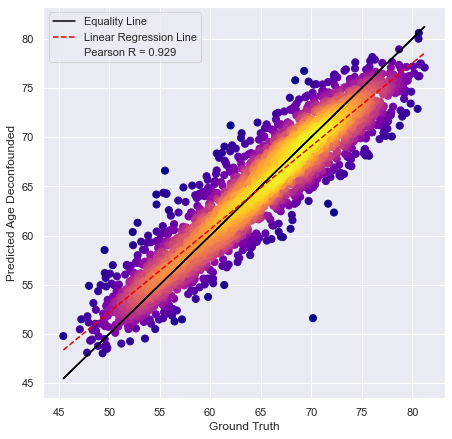

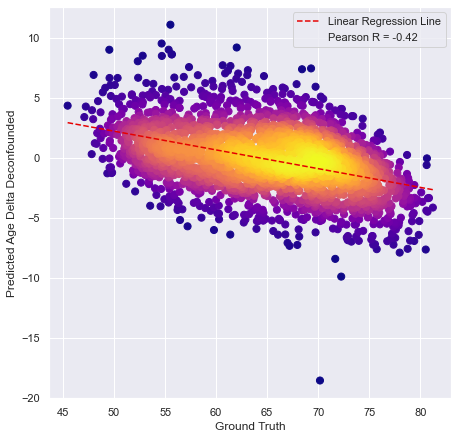

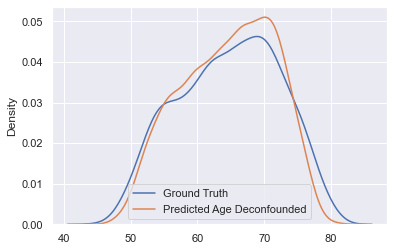

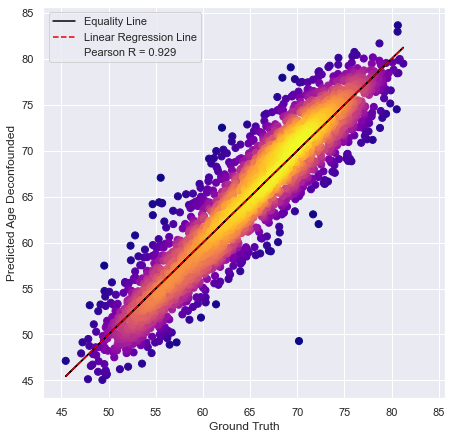

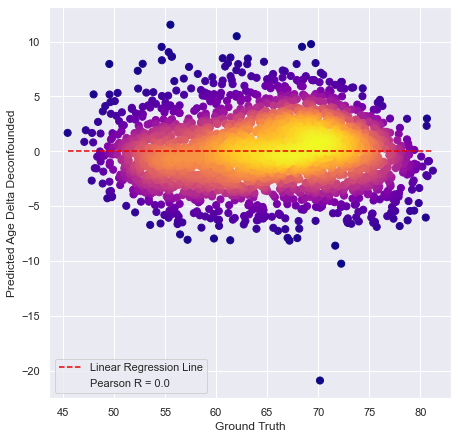

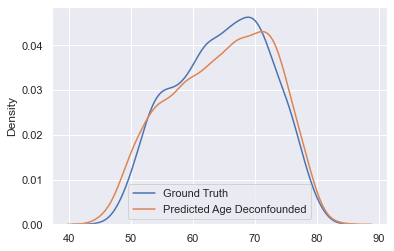

In [15]:
deconfound = True
verbose = True
show_plots = True

Age_Deltas = Yhat - Ytest

if deconfound == True:
    Yhat_decon = age_deconfounding(Yhat, Ytest)
    Age_Deltas_decon = Yhat_decon - Ytest
else:
    Yhat_decon = None
    Age_Deltas_decon = None
    
mae = np.abs(Age_Deltas).mean()
pr = pearsonr(Ytest, Yhat)[0]

if deconfound == True:
    mae_decon = np.abs(Age_Deltas_decon).mean()
    pr_decon = pearsonr(Ytest, Yhat_decon)[0]
else:
    mae_decon = None
    pr_decon = None

if verbose == True:
    print('MAE=', mae)
    print('PR=', pr)
    print('Time To Complete: {}'.format(end_time - start_time))
    if deconfound == True:
        print('MAE Decon=', mae_decon)
        print('PR Decon=', pr_decon)

if show_plots == True:
    scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                           ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

    scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                           ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                           equality_line=False)

    kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

    if deconfound == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            

In [16]:
df_output = pd.DataFrame.from_dict({
    'modality': 'MLP',
#     'dataframe': [pd.DataFrame.from_dict({
#             'Unnamed: 0': subjects_testB,
#             'age_delta_decon': Age_Deltas_decon
#             })]
#     })
    
    'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': Age_Deltas_decon,
                'mean_age_delta': Age_Deltas,
                'target_age': df_testB.target_age.values,
                'mean_output_age': Yhat
                })]
})

In [17]:
output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon mean_age_de...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon mean_age_de...
0,ElasticNetFull,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster1,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster2,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster3,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster4,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster5,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster6,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster7,Unnamed: 0 age_delta_decon mean_age_de...


In [17]:
df_output.iloc[0].dataframe

,Unnamed: 0,age_delta_decon
0,22840726,-4.641318
1,22538138,3.409633
2,23586213,-1.450601
3,23759858,2.639740
4,22751665,4.222225
...,...,...
2178,22793991,-2.138606
2179,22995420,5.188893
2180,21876262,3.690474
2181,24605415,-0.755427


In [18]:
output_name = 'male_ensembles_testset.pkl'
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2284...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2284...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster7,Unnamed: 0 age_delta_decon 0 2284...


In [68]:
df_ensambles.iloc[-2].dataframe

,Unnamed: 0,age_delta_decon
0,25731272,0.921214
1,23327192,-4.295156
2,21569423,-1.520484
3,25730176,-0.651774
4,23094690,1.951838
...,...,...
2506,23930771,-0.824926
2507,24847070,6.704910
2508,23169754,2.080495
2509,25240989,-2.651686


In [69]:
df_ensambles.iloc[np.where(df_ensambles.modality.to_numpy()=='MLP')[0][0]].dataframe 

,Unnamed: 0,age_delta_decon
0,25731272,0.921214
1,23327192,-4.295156
2,21569423,-1.520484
3,25730176,-0.651774
4,23094690,1.951838
...,...,...
2506,23930771,-0.824926
2507,24847070,6.704910
2508,23169754,2.080495
2509,25240989,-2.651686


In [79]:
df_ensambles.iloc[np.where(df_ensambles.modality.to_numpy()=='MLP')[0][0]].dataframe = df_output.dataframe[0]

In [80]:
df_ensambles.iloc[-2].dataframe

,Unnamed: 0,age_delta_decon
0,25731272,0.585977
1,23327192,-4.873305
2,21569423,-2.286288
3,25730176,-0.567158
4,23094690,1.461411
...,...,...
2506,23930771,-1.425889
2507,24847070,6.338881
2508,23169754,2.956663
2509,25240989,-3.053326


In [81]:
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2573...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2573...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2573...
0,RENT,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2573...


In [82]:
df_ensambles.to_pickle(output_name, protocol = 4)

In [84]:
df_ensambles2 = pd.read_pickle(output_name)
df_ensambles2.iloc[-2].dataframe

,Unnamed: 0,age_delta_decon
0,25731272,0.585977
1,23327192,-4.873305
2,21569423,-2.286288
3,25730176,-0.567158
4,23094690,1.461411
...,...,...
2506,23930771,-1.425889
2507,24847070,6.338881
2508,23169754,2.956663
2509,25240989,-3.053326


In [19]:
output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        df_ensambles.iloc[np.where(df_ensambles.modality.to_numpy()=='MLP')[0][0]].dataframe = df_output.dataframe[0]
        df_ensambles.to_pickle(output_name, protocol = 4)
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2284...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2284...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster7,Unnamed: 0 age_delta_decon 0 2284...


In [20]:
pd.read_pickle('male_test.pkl').modality

0     T1_nonlinear
1        T1_linear
2         jacobian
3              vbm
4     T2_nonlinear
5       T2_lesions
6              swi
7         rsfmri_0
8         rsfmri_1
9         rsfmri_2
10        rsfmri_3
11        rsfmri_4
12        rsfmri_5
13        rsfmri_6
14        rsfmri_7
15        rsfmri_8
16        rsfmri_9
17       rsfmri_10
18       rsfmri_11
19       rsfmri_12
20       rsfmri_13
21       rsfmri_14
22       rsfmri_15
23       rsfmri_16
24       rsfmri_17
25       rsfmri_18
26       rsfmri_19
27       rsfmri_20
28       rsfmri_21
29       rsfmri_22
30       rsfmri_23
31       rsfmri_24
32         tfmri_1
33         tfmri_2
34         tfmri_5
35       tfmri_c_1
36       tfmri_c_2
37       tfmri_c_5
38          tracts
39       tbss_FA_s
40     tbss_ICVF_s
41    tbss_ISOVF_s
42       tbss_L1_s
43       tbss_L2_s
44       tbss_L3_s
45       tbss_MD_s
46       tbss_MO_s
47       tbss_OD_s
48         tbss_FA
49       tbss_ICVF
50      tbss_ISOVF
51         tbss_L1
52         t

In [21]:
output_name = 'male_ensembles_testset.pkl'
df_ensambles = pd.read_pickle(output_name)
for idx in range(len(df_ensambles.modality)):
    mae_decon = np.abs(df_ensambles.iloc[idx].dataframe.age_delta_decon).mean()
    print("{:.3f}".format(mae_decon))

3.127
2.273
2.279
3.099
3.503
2.762
2.367
2.339
3.670
5.471
3.022
2.709
2.277
2.271
2.314
2.341


In [22]:
output_name = 'male_ensembles_testset.pkl'
df_ensambles = pd.read_pickle(output_name)
for idx in range(len(df_ensambles.modality)):
    mae_decon = np.abs(df_ensambles.iloc[idx].dataframe.age_delta_decon).mean()
    print(" {} - {:.3f}".format(df_ensambles.iloc[idx].modality, mae_decon))

 NaiveFull - 3.127
 LinearRegressionFull - 2.273
 ElasticNetFull - 2.279
 Cluster1 - 3.099
 Cluster2 - 3.503
 Cluster3 - 2.762
 Cluster4 - 2.367
 Cluster5 - 2.339
 Cluster6 - 3.670
 Cluster7 - 5.471
 Cluster8 - 3.022
 Cluster9 - 2.709
 Cluster10 - 2.277
 Cluster11 - 2.271
 RENT - 2.314
 MLP - 2.341


In [18]:
df = pd.read_pickle('male_ensembles_testset.pkl')

# mae_weighting = 37.137671232876755 # for female subjects
mae_weighting = 36.28150684931529 # for male subjects

modality_names = [
    'Naive Average', 'Linear Regression', 'ElasticNet', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
    'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'RENT', 'MLP'
]


from sklearn.model_selection import train_test_split

print("{:17} : {:7} | {:7} | {:10} | {:10}".format(
    'Modality', "MAE", "MEAN DECONF", "CORR (R)", "MAE weighted"  ) )
print('----------------------------------------------------------------------------------------------------------')

for idx in range(len(df)):
    
    print("{:17} : {:6.3f}  |  {:9.3f}  |  {:8.3f}  |  {:.3f} ".format(
        modality_names[idx],
        np.abs(df.iloc[idx].dataframe.mean_age_delta).mean(),
        np.abs(df.iloc[idx].dataframe.age_delta_decon).mean(),
        pearsonr(df.iloc[idx].dataframe.target_age, df.iloc[idx].dataframe.mean_output_age)[0],
        np.abs(df.iloc[idx].dataframe.mean_age_delta).mean() / mae_weighting,
    )
         )

Modality          : MAE     | MEAN DECONF | CORR (R)   | MAE weighted
----------------------------------------------------------------------------------------------------------
Naive Average     :  3.265  |      3.127  |     0.886  |  0.090 
Linear Regression :  2.124  |      2.273  |     0.934  |  0.059 
ElasticNet        :  2.127  |      2.279  |     0.934  |  0.059 
Cluster 1         :  2.733  |      3.099  |     0.888  |  0.075 
Cluster 2         :  3.047  |      3.503  |     0.862  |  0.084 
Cluster 3         :  2.510  |      2.762  |     0.906  |  0.069 
Cluster 4         :  2.194  |      2.367  |     0.930  |  0.060 
Cluster 5         :  2.164  |      2.339  |     0.932  |  0.060 
Cluster 6         :  3.127  |      3.670  |     0.854  |  0.086 
Cluster 7         :  4.121  |      5.471  |     0.739  |  0.114 
Cluster 8         :  2.678  |      3.022  |     0.892  |  0.074 
Cluster 9         :  2.457  |      2.709  |     0.910  |  0.068 
Cluster 10        :  2.127  |      2.277  |